# Training Code for the Continuous Control Project

By: Daniel Nehren
Date: 5/28/2020

In [1]:
%matplotlib inline

from unityagents import UnityEnvironment
import numpy as np
import random
import sys
from collections import deque

import ptan
import torch
import torch.optim as optim
import torch.nn.functional as F

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
sys.path.append('./')

In [3]:
from ddpg_model_ptan import AgentDDPG, DDPGActor,DDPGCritic,Config
from utils.experience_unity import UnityExperienceSourceFirstLast

### Setup

In [4]:
# Start Environment
env = UnityEnvironment(file_name='Reacher-2.app',no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

In [24]:
# Start Tensor board
writer = SummaryWriter(comment="-reacherddpg_ptan")

In [7]:
#Get the config for all hyperparameters
config = Config()

In [9]:
#Create the Actor and Critic networks

actor_net = DDPGActor(state_size,action_size,config.ACTOR_FC1_UNITS,config.ACTOR_FC2_UNITS)
critic_net = DDPGCritic(state_size,action_size,config.CRITIC_FC1_UNITS,config.CRITIC_FC2_UNITS)

act_opt = optim.Adam(actor_net.parameters(), lr=config.LR_ACTOR)
crt_opt = optim.Adam(critic_net.parameters(), lr=config.LR_CRITIC)

In [10]:
#Using PTAN Utilitiy for the Target networs
actor_target = ptan.agent.TargetNet(actor_net)
critic_target = ptan.agent.TargetNet(critic_net)

In [12]:
#Utility Function

def unpack_batch(batch, device="cpu"):
    """ Utility Function to unpack a batch of expeirences in to tensors for training"""
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v

def test_net(net, env, steps=100, device="cpu"):
    """Funtion to test the current environment just using the actor net"""
    
    env_info = env.reset(train_mode=True)[brain_name] 
    
    rewards = np.zeros((steps, len(env_info.rewards)))
                       
    for step in range(steps):
              
        states = env_info.vector_observations
        states_v = ptan.agent.float32_preprocessor(states).to(device)
        actions_v = net(states_v)
        actions = actions_v.squeeze(dim=0).data.cpu().numpy()
        actions = np.clip(actions, -1, 1)
        env_info= env.step(actions)[brain_name]
        rewards[step,:] += np.array(env_info.rewards)        
        
    return rewards.sum(axis=0).mean()

In [15]:
#Instantiate the Agent
agent = AgentDDPG(actor_net, device=config.device,ou_teta=config.NOISE_THETA,ou_sigma=config.NOISE_SIGMA)

In [25]:
# PTAN based utilities to setup the Replay Buffer

exp_source = UnityExperienceSourceFirstLast(env, agent, gamma=config.GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=config.BUFFER_SIZE)

### Training Loop

In [17]:
rewards_history = []
stop_score = 30

max_episodes = 10000

INITIAL_BUFFER_SIZE = 2000
MAX_STEPS = 1000

with ptan.common.utils.TBMeanTracker(writer, batch_size=1) as tb_tracker:
        
    #Prime the Replay Buffer    
    buffer.populate(INITIAL_BUFFER_SIZE)
    
    for episode in range(1,max_episodes+1):
        
        for step in range(MAX_STEPS):
            
            buffer.populate(20)
        
            batch = buffer.sample(config.BATCH_SIZE)
            states_v, actions_v, rewards_v, dones_mask, last_states_v = unpack_batch(batch, config.device)
            
            #Critic Training
            crt_opt.zero_grad()
            q_v = critic_net(states_v, actions_v)
            last_act_v = actor_target.target_model(last_states_v)
            q_last_v = critic_target.target_model(last_states_v, last_act_v)
            q_last_v[dones_mask] = 0.0
            q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * config.GAMMA
            critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
            critic_loss_v.backward()
            crt_opt.step()


            #Actor Training            
            act_opt.zero_grad()
            cur_actions_v = actor_net(states_v)
            actor_loss_v = -critic_net(states_v, cur_actions_v)
            actor_loss_v = actor_loss_v.mean()
            actor_loss_v.backward()
            act_opt.step()            

            actor_target.alpha_sync(alpha=1 - config.TAU)
            critic_target.alpha_sync(alpha=1 - config.TAU)
        
        #Update Tensorboard
        tb_tracker.track("loss_critic", critic_loss_v, episode)
        tb_tracker.track("critic_ref", q_ref_v.mean(), episode)
        tb_tracker.track("loss_actor", actor_loss_v, episode)
        
        reward = test_net(actor_net,env,MAX_STEPS)
        tb_tracker.track("reward", reward, episode)               
        rewards_history.append(reward)
        
        
        print(f'Episode: {episode} reward: {reward}',end='\r')
        
        reward_100 = np.mean(rewards_history[-100:])
        
        tb_tracker.track("reward_100", reward_100, episode)
        
        if episode % 10 == 0:
            print(f'Episode: {episode} reward_100: {reward_100}')
        
        
        if len(rewards_history) > 100 and reward_100 > stop_score:
            print(f'Solved. Episode {episode}, mean reward {reward_100}')
            break
    
    #When Done save the training state
    learning_state = {
        'actor': actor_net.state_dict(),
        'critic': critic_net.state_dict(),
        'act_opt': act_opt.state_dict(),
        'crt_opt': crt_opt.state_dict(),
        'episode': episode,
        'rewards_history': rewards_history
    }
    
    torch.save(learning_state,'./solved_state.ckp')
    
    writer.close()
    env.close()
    

Episode: 10 reward_100: 0.7169499839749187
Episode: 20 reward_100: 0.6717999849840999
Episode: 30 reward_100: 0.6599166519163798
Episode: 40 reward_100: 0.6634249851712957
Episode: 50 reward_100: 0.672089984977618
Episode: 60 reward_100: 0.7283499837201087
Episode: 70 reward_100: 0.8167785531721478
Episode: 80 reward_100: 0.8976812299352606
Episode: 90 reward_100: 0.9627333118145665
Episode: 100 reward_100: 1.060129976304248
Episode: 110 reward_100: 1.1833999735489487
Episode: 120 reward_100: 1.3252799703776836
Episode: 130 reward_100: 1.4652799672484398
Episode: 140 reward_100: 1.6560649629840625
Episode: 150 reward_100: 1.9095399573184548
Episode: 160 reward_100: 2.14233995211497
Episode: 170 reward_100: 2.433184945614077
Episode: 180 reward_100: 2.763284938235768
Episode: 190 reward_100: 3.320804925774224
Episode: 200 reward_100: 4.060154909248463
Episode: 210 reward_100: 5.064969886789099
Episode: 220 reward_100: 6.2929098593425
Episode: 230 reward_100: 7.606299829985947
Episode: 2

### Results

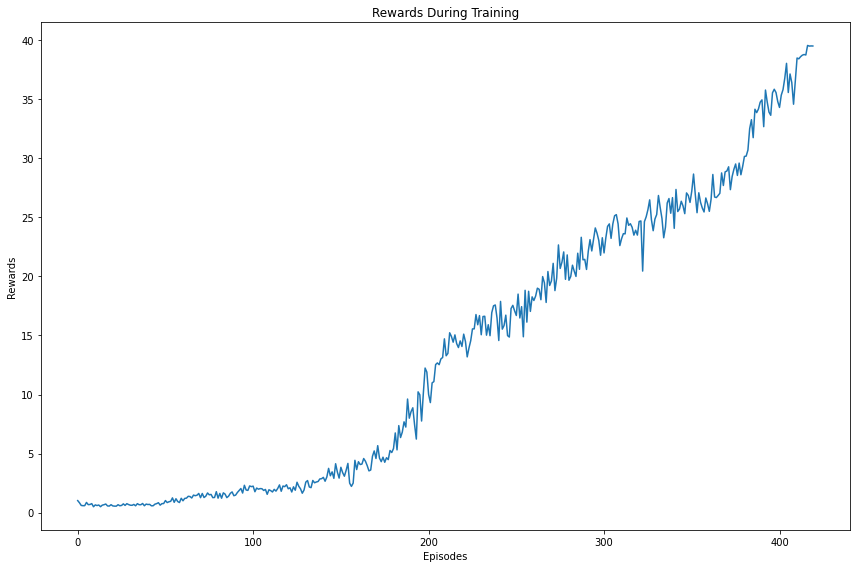

In [29]:
#Plot Rewards History
fix,ax = plt.subplots(figsize=(12,8))
_ = plt.plot(rewards_history)
_ = plt.title("Rewards During Training")
_ = plt.xlabel('Episodes')
_ = plt.ylabel('Rewards')
plt.tight_layout()
plt.show()

In [30]:
#Save Rewards History
np.save('./rewards_history',rewards_history)